In [24]:
import pandas as pd

# Load dataset
df = pd.read_excel(r"C:\Users\kfq6\Documents\Data\Sammedag_master_means.xlsx")

# Basic info
print("Shape:", df.shape)
print("\n--- Column Overview ---")
print(df.info())

# Check for missing values
print("\n--- Missing Values ---")
print(df.isna().sum())

# Check unique patient IDs
ID_COL = "DW_EK_Borger"  # change if your ID column is named differently
print("\n--- Patient ID Check ---")
print(f"Unique IDs: {df[ID_COL].nunique()}")
print(f"Total rows: {len(df)}")

# Optionally, show duplicates if they exist
duplicates = df[df.duplicated(subset=[ID_COL], keep=False)]
if not duplicates.empty:
    print("\n--- Duplicate IDs ---")
    print(duplicates.sort_values(by=ID_COL))
else:
    print("\nNo duplicate patient IDs found.")

# --- Keep only patients with ≥2 rows (drop single-visit patients) ---
patient_counts = df.groupby(ID_COL).size()

multi_ids = patient_counts[patient_counts >= 2].index

print(f"\nKeeping only patients with ≥2 rows...")
print(f"Patients before filter: {patient_counts.shape[0]:,}")
print(f"Patients with ≥2 rows:  {len(multi_ids):,}")
print(f"Patients dropped (only 1 row): {(patient_counts.shape[0] - len(multi_ids)):,}")

# Overwrite df with multi-row cohort
df = df[df[ID_COL].isin(multi_ids)].copy()

print(f"\nFiltered dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients after filter: {df[ID_COL].nunique():,}")


Shape: (4597, 36)

--- Column Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597 entries, 0 to 4596
Data columns (total 36 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   DW_EK_Borger                                              4597 non-null   int64         
 1   sex                                                       4597 non-null   object        
 2   age                                                       4597 non-null   float64       
 3   diagnosis                                                 4597 non-null   object        
 4   anchor_date                                               4597 non-null   datetime64[ns]
 5   window_start                                              4597 non-null   datetime64[ns]
 6   window_end                                                4597 non-null   datetime64[ns]
 7  

In [48]:
# --- Check if certain patient IDs (e.g. hospitalized patients) exist in the master dataset ---

# hospitalized patient IDs
hospitalized_ids = [143581, 443158, 461784, 700244, 998971, 1006451, 1082134, 1114165, 1220750 ,1233676, 1237827, 1268194]

# Convert to the same dtype as in df (important for matching)
hospitalized_ids = [int(x) for x in hospitalized_ids]
df[ID_COL] = df[ID_COL].astype(int)

# Check which IDs exist
existing_ids = df[df[ID_COL].isin(hospitalized_ids)][ID_COL].unique()
missing_ids  = [i for i in hospitalized_ids if i not in existing_ids]

print(f"Total hospitalized patients checked: {len(hospitalized_ids)}")
print(f"Found in master dataset: {len(existing_ids)}")
print(f"Missing from master dataset: {len(missing_ids)}")

if len(existing_ids) > 0:
    print("\nIDs found in dataset:")
    print(existing_ids)
if len(missing_ids) > 0:
    print("\nIDs missing from dataset:")
    print(missing_ids)

# Optional: subset only hospitalized patients if you need it for further analysis
df_hosp = df[df[ID_COL].isin(hospitalized_ids)].copy()
print(f"\nSubset of hospitalized patients: {df_hosp.shape[0]} rows from {df_hosp[ID_COL].nunique()} unique patients.")


Total hospitalized patients checked: 12
Found in master dataset: 0
Missing from master dataset: 12

IDs missing from dataset:
[143581, 443158, 461784, 700244, 998971, 1006451, 1082134, 1114165, 1220750, 1233676, 1237827, 1268194]

Subset of hospitalized patients: 0 rows from 0 unique patients.


In [25]:
import pandas as pd
import numpy as np

# ---------------------------
# Constants
# ---------------------------
ID_COL = "DW_EK_Borger"
DATE_COLS = ["anchor_date", "window_start", "window_end",
             "lab_window_start", "lab_window_end", "who_date"]
DIAG_COLS = ["diagnosis_y", "diagnosis_x"]  # prefer 'y' if present
LAB_PREFIX = "LABmean__"

# Ensure datetime
for c in DATE_COLS:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Collect lab columns
lab_cols = [c for c in df.columns if c.startswith(LAB_PREFIX)]
# Make sure lab cols are numeric
df[lab_cols] = df[lab_cols].apply(pd.to_numeric, errors="coerce")


Distribution of sammedagsscreening per patient:

2    701
3    862
4     45
Name: count, dtype: int64

Summary stats:
count    1608.000000
mean        2.592040
std         0.545604
min         2.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
dtype: float64


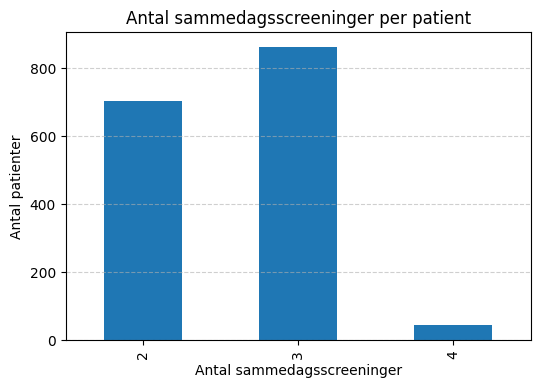

In [26]:
# --- Count sammedagsscreening per patient ---
screenings_per_patient = df.groupby(ID_COL).size()

# --- Basic stats ---
print("Distribution of sammedagsscreening per patient:\n")
print(screenings_per_patient.value_counts().sort_index())

print("\nSummary stats:")
print(screenings_per_patient.describe())

# Optional: visualize (requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
screenings_per_patient.value_counts().sort_index().plot(kind='bar')
plt.title("Antal sammedagsscreeninger per patient")
plt.xlabel("Antal sammedagsscreeninger")
plt.ylabel("Antal patienter")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [27]:
# Prefer diagnosis_y, then fallback to diagnosis_x
tmp = df[DIAG_COLS].copy()
df["diagnosis"] = tmp.bfill(axis=1).iloc[:, 0].fillna("Unknown")

diag_counts = df["diagnosis"].value_counts(dropna=False)
diag_share = (diag_counts / len(df)).round(4)

print("\nDiagnosis counts:\n", diag_counts)
print("\nDiagnosis share:\n", diag_share)

# Cross-tab: diagnosis by has_lab_in_window
if "has_lab_in_window" in df.columns:
    print("\nDiagnosis × has_lab_in_window:\n")
    display(pd.crosstab(df["diagnosis"], df["has_lab_in_window"], margins=True))


KeyError: "None of [Index(['diagnosis_y', 'diagnosis_x'], dtype='object')] are in the [columns]"

In [28]:
who_cols = ["has_who_in_window", "who_score", "who_days_from_anchor"]
present = [c for c in who_cols if c in df.columns]
print("\nWHO columns present:", present)

if "has_who_in_window" in df.columns:
    print("\nWHO present value counts:\n", df["has_who_in_window"].value_counts(dropna=False))

if "who_score" in df.columns:
    print("\nWHO score describe:\n", df["who_score"].describe())



WHO columns present: ['has_who_in_window', 'who_score', 'who_days_from_anchor']

WHO present value counts:
 has_who_in_window
True     2584
False    1584
Name: count, dtype: int64

WHO score describe:
 count    2584.000000
mean       61.507740
std        20.507365
min         0.000000
25%        48.000000
50%        68.000000
75%        76.000000
max       100.000000
Name: who_score, dtype: float64


In [30]:
print("\n# of lab columns detected:", len(lab_cols))
print("\n% missing per lab (top 10 most missing):")
miss = df[lab_cols].isna().mean().sort_values(ascending=False)
display((100 * miss).round(1).head(10).to_frame("% missing"))

print("\nBasic lab stats (mean/SD/min/max) — transposed for readability:")
basic = df[lab_cols].describe().T
display(basic[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].round(3).head(15))



# of lab columns detected: 17

% missing per lab (top 10 most missing):


,% missing
LABmean__U-Albumin / Kreatinin-ratio_[× 10<sup>-3</sup>],93.6
LABmean__P-Calcium (albuminkorrigeret)_[mmol/l],87.3
LABmean__P-Calcium_[mmol/l],87.3
LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l],84.9
LABmean__P-Albumin_[g/l],82.6
LABmean__U-Albumin / Kreatinin-ratio_[mg/g],20.1
LABmean__B-Hæmoglobin_[mmol/l],19.8
LABmean__P-Kolesterol LDL_[mmol/l],6.4
LABmean__P-Vitamin B12_[pmol/l],4.8
LABmean__P-Kolesterol HDL_[mmol/l],4.5



Basic lab stats (mean/SD/min/max) — transposed for readability:


,count,mean,std,min,25%,50%,75%,max
LABmean__B-Hæmoglobin_[mmol/l],3344.0,8.702,0.951,4.700,8.10,8.70,9.400,12.500
LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol],4008.0,62.125,13.595,26.000,53.00,60.00,69.000,143.667
LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l],628.0,72.752,32.726,13.000,49.00,71.00,93.000,275.000
LABmean__P-Albumin_[g/l],726.0,38.517,4.379,20.657,36.00,39.00,41.000,49.000
LABmean__P-Calcium (albuminkorrigeret)_[mmol/l],530.0,2.371,0.106,2.040,2.31,2.36,2.440,2.790
LABmean__P-Calcium_[mmol/l],530.0,2.347,0.124,1.920,2.28,2.35,2.425,2.720
LABmean__P-Kalium_[mmol/l],3995.0,4.047,0.351,2.600,3.80,4.00,4.300,5.900
LABmean__P-Kolesterol HDL_[mmol/l],3981.0,1.440,0.422,0.445,1.10,1.40,1.700,3.400
LABmean__P-Kolesterol LDL_[mmol/l],3903.0,2.314,0.773,0.100,1.80,2.20,2.750,6.300
LABmean__P-Kolesterol_[mmol/l],3982.0,4.326,0.927,1.800,3.70,4.30,4.900,9.500


In [31]:
# Average lab values per diagnosis (only if not too many categories)
diag_means = (
    df.groupby("diagnosis")[lab_cols]
      .mean(numeric_only=True)
      .round(3)
      .sort_index()
)
print("\nMean lab values per diagnosis (first 10 labs):")
display(diag_means.iloc[:, :10])



Mean lab values per diagnosis (first 10 labs):


,LABmean__B-Hæmoglobin_[mmol/l],LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol],LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l],LABmean__P-Albumin_[g/l],LABmean__P-Calcium (albuminkorrigeret)_[mmol/l],LABmean__P-Calcium_[mmol/l],LABmean__P-Kalium_[mmol/l],LABmean__P-Kolesterol HDL_[mmol/l],LABmean__P-Kolesterol LDL_[mmol/l],LABmean__P-Kolesterol_[mmol/l]
diagnosis,,,,,,,,,,
Andre former for diabetes,8.434,61.148,80.778,37.806,2.366,2.346,4.058,1.474,1.927,4.051
Ikke specificeret diabetes,8.250,64.667,NaN,NaN,NaN,NaN,4.200,2.067,2.800,5.433
Type 1-diabetes,8.716,61.839,70.888,38.976,2.365,2.347,4.031,1.506,2.403,4.403
Type 2-diabetes,8.681,63.646,79.592,37.639,2.383,2.349,4.119,1.113,1.912,3.995


In [39]:
# %%
# ------------- CONFIG -------------
ID_COL = "DW_EK_Borger"
DATE_COL = "anchor_date"

# --- Auto-detect HbA1c and eGFR columns ---
hba1c_candidates = [c for c in df.columns if "LABmean" in c and ("A1c" in c or "HbA1c" in c)]
egfr_candidates  = [c for c in df.columns if "LABmean" in c and "eGFR" in c]

if not hba1c_candidates or not egfr_candidates:
    raise ValueError("Check column names: could not auto-detect HbA1c / eGFR LABmean__ columns.")

HBA1C_COL = hba1c_candidates[0]
EGFR_COL  = egfr_candidates[0]

print(f"Using HbA1c column: {HBA1C_COL}")
print(f"Using eGFR column:  {EGFR_COL}")

# --- Ensure types ---
df[DATE_COL]    = pd.to_datetime(df[DATE_COL], errors="coerce")
df[HBA1C_COL]   = pd.to_numeric(df[HBA1C_COL], errors="coerce")
df[EGFR_COL]    = pd.to_numeric(df[EGFR_COL], errors="coerce")

# --- Sort dataset chronologically per patient ---
df_sorted = df.sort_values([ID_COL, DATE_COL])
print(f"All rows retained for analysis: {df_sorted.shape[0]:,} (covering {df_sorted[ID_COL].nunique():,} patients)")


Using HbA1c column: LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol]
Using eGFR column:  LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min]
All rows retained for analysis: 4,168 (covering 1,608 patients)



HbA1c (all measurements) summary:
count    4008.00
mean       62.12
std        13.59
min        26.00
5%         44.00
25%        53.00
50%        60.00
75%        69.00
95%        88.00
max       143.67
Name: LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol], dtype: float64

HbA1c bands (all rows):
≤53 mmol/mol:   1043 (26.0%)
>53–64 mmol/mol: 1527 (38.1%)
≥75 mmol/mol:   597 (14.9%)


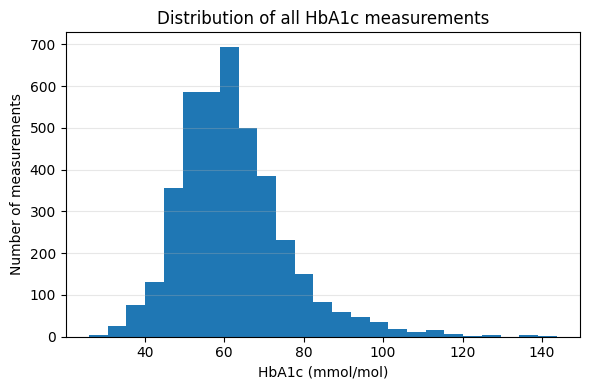

In [40]:
# %%
import matplotlib.pyplot as plt
import numpy as np

# ------------- ALL HbA1c MEASUREMENTS -------------
all_hba1c = df_sorted[HBA1C_COL].dropna()

print("\nHbA1c (all measurements) summary:")
print(all_hba1c.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

# HbA1c bands: ≤53, 53–64, ≥75 mmol/mol
hba1c_le_53 = (all_hba1c <= 53).sum()
hba1c_53_64 = ((all_hba1c > 53) & (all_hba1c <= 64)).sum()
hba1c_ge_75 = (all_hba1c >= 75).sum()

total = len(all_hba1c)
print("\nHbA1c bands (all rows):")
print(f"≤53 mmol/mol:   {hba1c_le_53} ({hba1c_le_53/total:.1%})")
print(f">53–64 mmol/mol: {hba1c_53_64} ({hba1c_53_64/total:.1%})")
print(f"≥75 mmol/mol:   {hba1c_ge_75} ({hba1c_ge_75/total:.1%})")

plt.figure(figsize=(6,4))
plt.hist(all_hba1c, bins=25)
plt.xlabel("HbA1c (mmol/mol)")
plt.ylabel("Number of measurements")
plt.title("Distribution of all HbA1c measurements")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()





eGFR (all measurements) summary:
count    4005.00
mean       81.22
std        17.34
min         4.00
5%         42.00
25%        78.00
50%        90.00
75%        90.00
95%        90.00
max       148.00
Name: LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min], dtype: float64


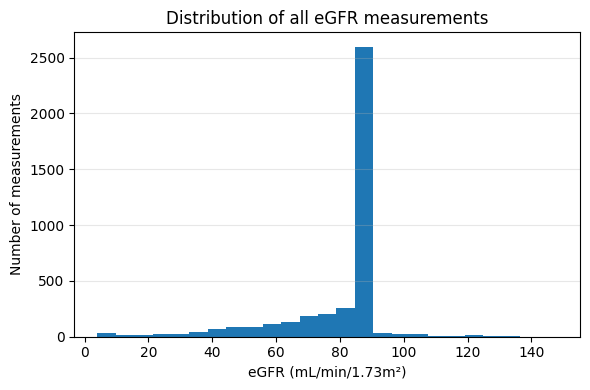


Patient-level average HbA1c & eGFR (each patient’s mean across visits):
       Mean HbA1c  Mean eGFR
count     1608.00    1607.00
mean        62.44      81.44
std         12.85      16.95
min         29.00       4.22
25%         54.00      78.33
50%         61.00      90.00
75%         68.50      90.00
max        126.00     136.00


In [41]:
# ------------- ALL eGFR MEASUREMENTS -------------
all_egfr = df_sorted[EGFR_COL].dropna()

print("\neGFR (all measurements) summary:")
print(all_egfr.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(all_egfr, bins=25)
plt.xlabel("eGFR (mL/min/1.73m²)")
plt.ylabel("Number of measurements")
plt.title("Distribution of all eGFR measurements")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: quick look at patient-level averages
per_patient_means = (
    df_sorted.groupby(ID_COL)[[HBA1C_COL, EGFR_COL]]
    .mean(numeric_only=True)
    .rename(columns={HBA1C_COL: "Mean HbA1c", EGFR_COL: "Mean eGFR"})
)

print("\nPatient-level average HbA1c & eGFR (each patient’s mean across visits):")
print(per_patient_means.describe().round(2))


Year-to-year pairs (patients with ≥2 screenings): 2537

HbA1c year-to-year change (mmol/mol) summary:
count    2391.00
mean       -0.95
std         9.82
min       -69.00
5%        -17.00
25%        -6.00
50%        -0.50
75%         4.00
95%        13.00
max        77.00
Name: HbA1c_change, dtype: float64


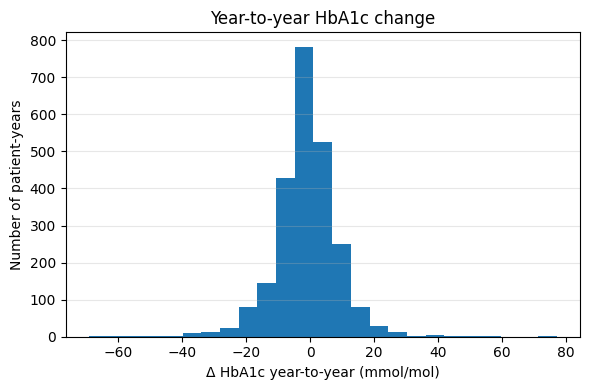


eGFR absolute year-to-year change (mL/min/1.73m²) summary:
count    2391.00
mean       -0.40
std         6.63
min       -32.67
5%        -12.00
25%        -1.00
50%         0.00
75%         0.00
95%        10.00
max        58.00
Name: eGFR_abs_change, dtype: float64

eGFR % year-to-year change summary:
count    2391.00
mean       -0.52
std        12.27
min       -61.90
5%        -17.01
25%        -1.11
50%         0.00
75%         0.00
95%        14.71
max       357.29
Name: eGFR_pct_change, dtype: float64


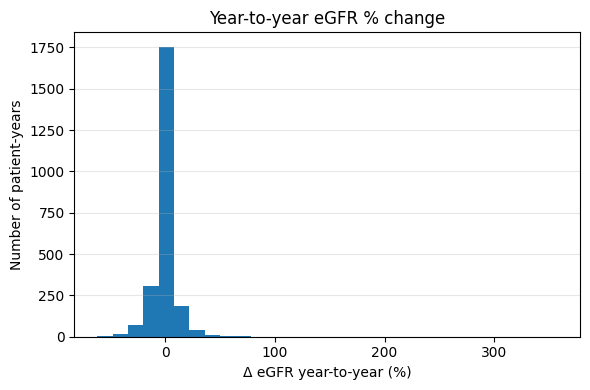

In [42]:
# ------------- YEAR-TO-YEAR CHANGES -------------
# Compute lagged values per patient
df_sorted["HbA1c_prev"] = df_sorted.groupby(ID_COL)[HBA1C_COL].shift(1)
df_sorted["eGFR_prev"]  = df_sorted.groupby(ID_COL)[EGFR_COL].shift(1)

# Only rows with a previous year available
chg = df_sorted.dropna(subset=["HbA1c_prev", "eGFR_prev"]).copy()

# HbA1c absolute change (mmol/mol)
chg["HbA1c_change"] = chg[HBA1C_COL] - chg["HbA1c_prev"]

# eGFR absolute and % change
chg["eGFR_abs_change"] = chg[EGFR_COL] - chg["eGFR_prev"]
chg["eGFR_pct_change"] = (chg["eGFR_abs_change"] / chg["eGFR_prev"]) * 100

print(f"\nYear-to-year pairs (patients with ≥2 screenings): {len(chg)}")

print("\nHbA1c year-to-year change (mmol/mol) summary:")
print(chg["HbA1c_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(chg["HbA1c_change"].dropna(), bins=25)
plt.xlabel("Δ HbA1c year-to-year (mmol/mol)")
plt.ylabel("Number of patient-years")
plt.title("Year-to-year HbA1c change")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\neGFR absolute year-to-year change (mL/min/1.73m²) summary:")
print(chg["eGFR_abs_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

print("\neGFR % year-to-year change summary:")
print(chg["eGFR_pct_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(chg["eGFR_pct_change"].dropna(), bins=30)
plt.xlabel("Δ eGFR year-to-year (%)")
plt.ylabel("Number of patient-years")
plt.title("Year-to-year eGFR % change")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [43]:
# ------------- eGFR % CHANGE BANDS (5%-STEPS) -------------
# Bins: 5%-steps from -30% to +30%, with tails
bins = [-np.inf,
        -30, -25, -20, -15, -10, -5,
         0,
         5, 10, 15, 20, 25, 30,
         np.inf]

labels = [
    "<-30%",
    "-30 to -25%",
    "-25 to -20%",
    "-20 to -15%",
    "-15 to -10%",
    "-10 to -5%",
    "-5 to 0%",
    "0 to 5%",
    "5 to 10%",
    "10 to 15%",
    "15 to 20%",
    "20 to 25%",
    "25 to 30%",
    ">30%"
]

chg["eGFR_pct_band"] = pd.cut(chg["eGFR_pct_change"], bins=bins, labels=labels, right=True, include_lowest=True)
band_counts = chg["eGFR_pct_band"].value_counts().sort_index()

print("\neGFR % change bands (year-to-year):")
print(band_counts.to_frame("n").assign(pct=lambda x: (x["n"] / x["n"].sum() * 100).round(1)))


eGFR % change bands (year-to-year):
                  n   pct
eGFR_pct_band            
<-30%            24   1.0
-30 to -25%      25   1.0
-25 to -20%      42   1.8
-20 to -15%      62   2.6
-15 to -10%     113   4.7
-10 to -5%      174   7.3
-5 to 0%       1449  60.6
0 to 5%         196   8.2
5 to 10%        108   4.5
10 to 15%        82   3.4
15 to 20%        52   2.2
20 to 25%        23   1.0
25 to 30%        15   0.6
>30%             26   1.1


Dataset contains 4,168 rows and 1,608 unique patients.

=== VARIABLE COMPLETENESS OVERVIEW ===


,Variable,% Missing,Unique values,Mean,SD,Flag
0,DW_EK_Borger,0.000000,1608,668255.053000,374579.769000,Good (≥80% non-missing)
18,lab_window_n_rows,0.000000,22,1.422000,1.551000,Good (≥80% non-missing)
16,lab_window_start,0.000000,660,nan,nan,Non-numeric or categorical
15,has_lab_in_window,0.000000,2,0.967000,0.178000,Good (≥80% non-missing)
11,has_who_in_window,0.000000,2,0.620000,0.485000,Good (≥80% non-missing)
10,visit_statuses,0.000000,150,nan,nan,Non-numeric or categorical
9,visit_topics,0.000000,1499,nan,nan,Non-numeric or categorical
8,visit_datetimes,0.000000,3147,nan,nan,Non-numeric or categorical
17,lab_window_end,0.000000,656,nan,nan,Non-numeric or categorical
6,window_end,0.000000,42,nan,nan,Non-numeric or categorical



=== COVERAGE BY CLINICAL GROUP ===

HbA1c: 1 col(s): ['LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol]']
  → Patients with ≥1 value: 100.0%
  Flag: GOOD coverage

eGFR: 1 col(s): ['LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min]']
  → Patients with ≥1 value: 99.9%
  Flag: GOOD coverage

Creatinine: 1 col(s): ['LABmean__P-Kreatinin_[µmol/l]']
  → Patients with ≥1 value: 99.9%
  Flag: GOOD coverage

Lipids: 4 col(s): ['LABmean__P-Kolesterol_[mmol/l]', 'LABmean__P-Kolesterol LDL_[mmol/l]', 'LABmean__P-Kolesterol HDL_[mmol/l]', 'LABmean__P-Triglycerid_[mmol/l]']
  → Patients with ≥1 value: 99.9%
  Flag: GOOD coverage

WHO-5: 1 col(s): ['who_score']
  → Patients with ≥1 value: 83.6%
  Flag: GOOD coverage

Albumin: 2 col(s): ['LABmean__P-Albumin_[g/l]', 'LABmean__U-Albumin / Kreatinin-ratio_[mg/g]']
  → Patients with ≥1 value: 98.6%
  Flag: GOOD coverage

Electrolytes: 4 col(s): ['LABmean__P-Kalium_[mmol/l]', 'LABmean__P-Natrium_[mmol/l]', 'LABmean__P-Calcium (albuminkorrigeret)_[mmol/l]', 'LABmea

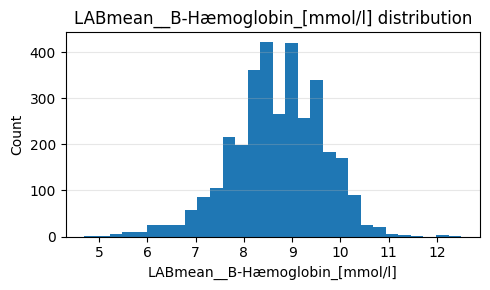


LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol] — 4008 values
count    4008.00
mean       62.12
std        13.59
min        26.00
5%         44.00
25%        53.00
50%        60.00
75%        69.00
95%        88.00
max       143.67
Name: LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol], dtype: float64


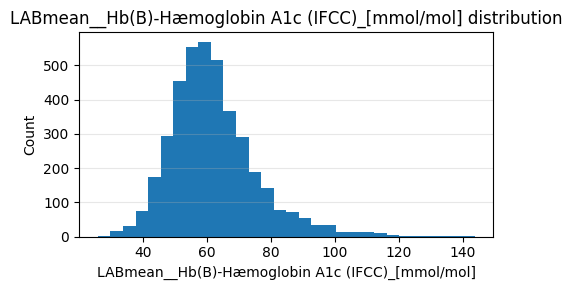


LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l] — 628 values
count    628.00
mean      72.75
std       32.73
min       13.00
5%        24.00
25%       49.00
50%       71.00
75%       93.00
95%      126.65
max      275.00
Name: LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l], dtype: float64


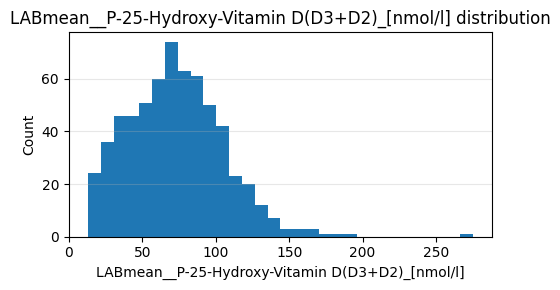


LABmean__P-Albumin_[g/l] — 726 values
count    726.00
mean      38.52
std        4.38
min       20.66
5%        30.36
25%       36.00
50%       39.00
75%       41.00
95%       45.00
max       49.00
Name: LABmean__P-Albumin_[g/l], dtype: float64


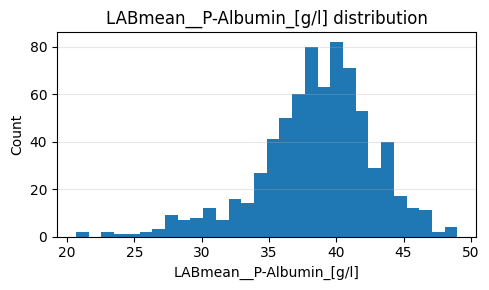


LABmean__P-Calcium (albuminkorrigeret)_[mmol/l] — 530 values
count    530.00
mean       2.37
std        0.11
min        2.04
5%         2.20
25%        2.31
50%        2.36
75%        2.44
95%        2.55
max        2.79
Name: LABmean__P-Calcium (albuminkorrigeret)_[mmol/l], dtype: float64


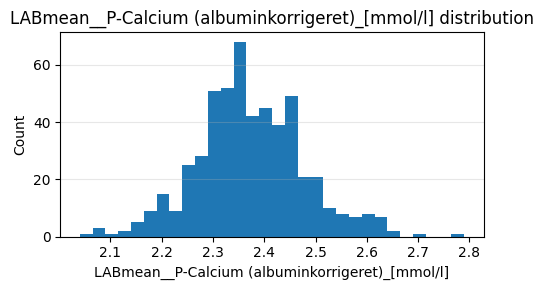


LABmean__P-Calcium_[mmol/l] — 530 values
count    530.00
mean       2.35
std        0.12
min        1.92
5%         2.14
25%        2.28
50%        2.35
75%        2.42
95%        2.56
max        2.72
Name: LABmean__P-Calcium_[mmol/l], dtype: float64


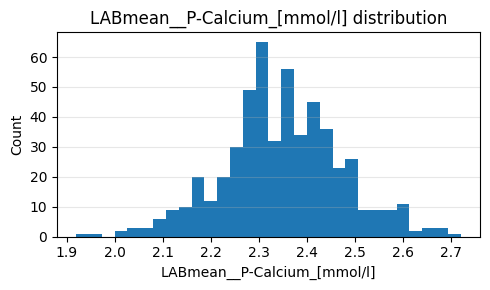


LABmean__P-Kalium_[mmol/l] — 3995 values
count    3995.00
mean        4.05
std         0.35
min         2.60
5%          3.50
25%         3.80
50%         4.00
75%         4.30
95%         4.60
max         5.90
Name: LABmean__P-Kalium_[mmol/l], dtype: float64


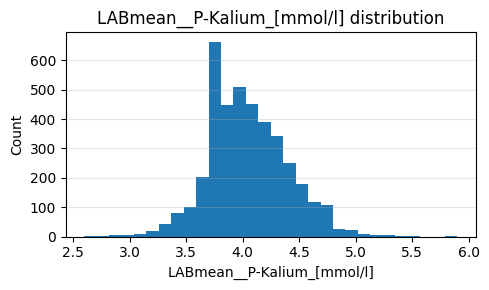


LABmean__P-Kolesterol HDL_[mmol/l] — 3981 values
count    3981.00
mean        1.44
std         0.42
min         0.44
5%          0.85
25%         1.10
50%         1.40
75%         1.70
95%         2.20
max         3.40
Name: LABmean__P-Kolesterol HDL_[mmol/l], dtype: float64


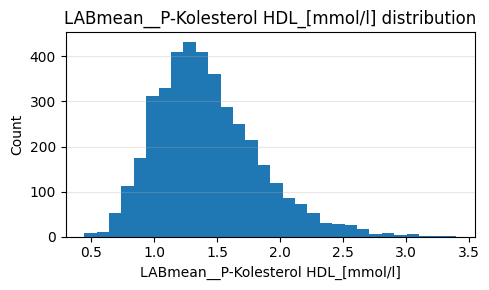


LABmean__P-Kolesterol LDL_[mmol/l] — 3903 values
count    3903.00
mean        2.31
std         0.77
min         0.10
5%          1.20
25%         1.80
50%         2.20
75%         2.75
95%         3.70
max         6.30
Name: LABmean__P-Kolesterol LDL_[mmol/l], dtype: float64


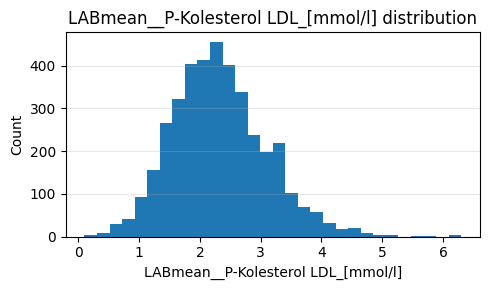


LABmean__P-Kolesterol_[mmol/l] — 3982 values
count    3982.00
mean        4.33
std         0.93
min         1.80
5%          3.00
25%         3.70
50%         4.30
75%         4.90
95%         5.90
max         9.50
Name: LABmean__P-Kolesterol_[mmol/l], dtype: float64


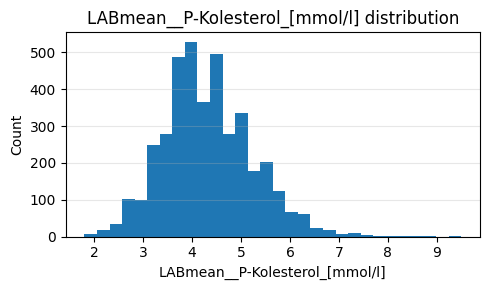


LABmean__P-Kreatinin_[µmol/l] — 4005 values
count    4005.00
mean       84.36
std        66.27
min        20.00
5%         51.00
25%        63.00
50%        73.00
75%        85.00
95%       136.00
max       997.14
Name: LABmean__P-Kreatinin_[µmol/l], dtype: float64


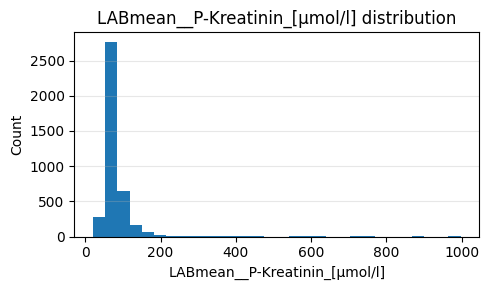


LABmean__P-Natrium_[mmol/l] — 3999 values
count    3999.00
mean      139.26
std         2.49
min       127.29
5%        135.00
25%       138.00
50%       139.00
75%       141.00
95%       143.00
max       148.12
Name: LABmean__P-Natrium_[mmol/l], dtype: float64


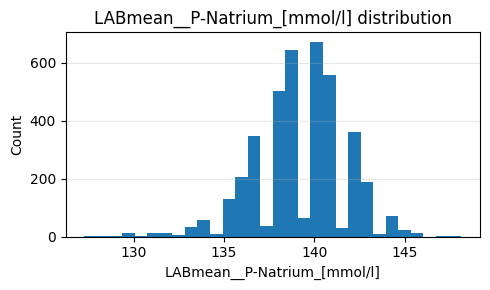


LABmean__P-Triglycerid_[mmol/l] — 3982 values
count    3982.00
mean        1.35
std         1.62
min         0.20
5%          0.50
25%         0.70
50%         1.00
75%         1.54
95%         3.10
max        64.20
Name: LABmean__P-Triglycerid_[mmol/l], dtype: float64


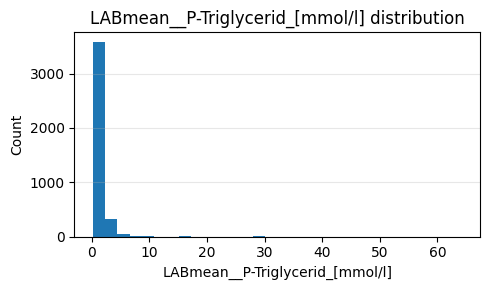


LABmean__P-Vitamin B12_[pmol/l] — 3966 values
count    3966.00
mean      401.69
std       188.48
min       109.00
5%        191.00
25%       277.00
50%       363.00
75%       478.00
95%       731.75
max      1476.00
Name: LABmean__P-Vitamin B12_[pmol/l], dtype: float64


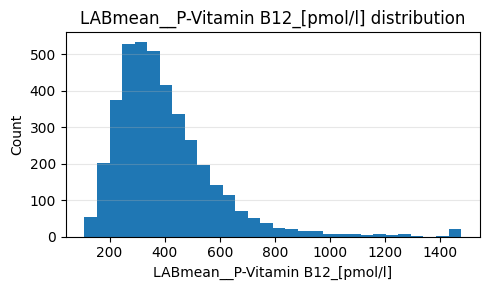


LABmean__U-Albumin / Kreatinin-ratio_[mg/g] — 3329 values
count     3329.00
mean       126.86
std        578.26
min          2.00
5%           4.00
25%          6.00
50%         12.00
75%         31.00
95%        454.00
max      11441.00
Name: LABmean__U-Albumin / Kreatinin-ratio_[mg/g], dtype: float64


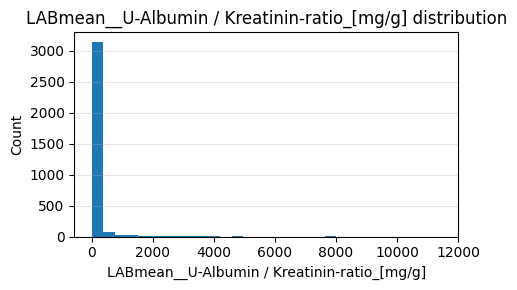


LABmean__U-Albumin / Kreatinin-ratio_[× 10<sup>-3</sup>] — 266 values
count     266.00
mean      191.08
std       680.81
min         2.60
5%          3.72
25%         6.82
50%        17.05
75%        64.58
95%       798.56
max      5998.10
Name: LABmean__U-Albumin / Kreatinin-ratio_[× 10<sup>-3</sup>], dtype: float64


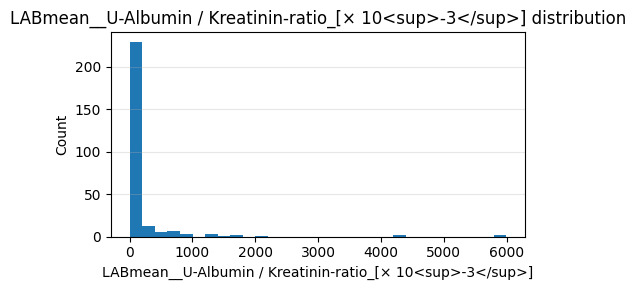


LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min] — 4005 values
count    4005.00
mean       81.22
std        17.34
min         4.00
5%         42.00
25%        78.00
50%        90.00
75%        90.00
95%        90.00
max       148.00
Name: LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min], dtype: float64


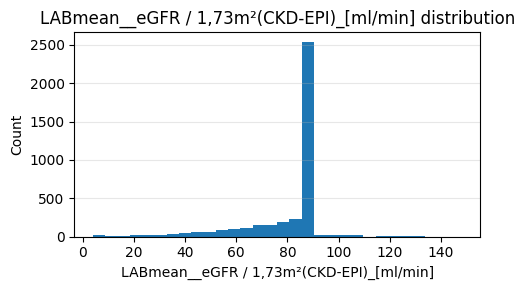


who_score — 2584 values
count    2584.00
mean       61.51
std        20.51
min         0.00
5%         20.00
25%        48.00
50%        68.00
75%        76.00
95%        88.00
max       100.00
Name: who_score, dtype: float64


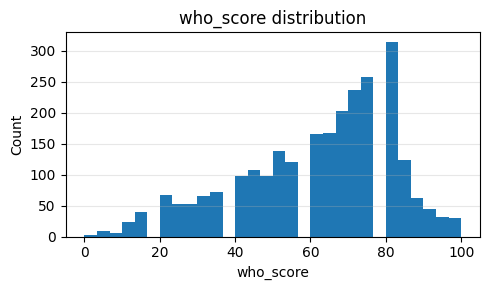


=== INTERPRETATION ===
1. Columns flagged 'Good' are ready for modelling.
2. 'Moderate' can be imputed (e.g., median or regression imputation).
3. 'Weak' should be excluded or used only in sensitivity tests.
4. Check WHO-5: if <60–70% coverage, include it only in a subset model.
5. If any lipid components are missing >40%, consider aggregating to a composite lipid ratio.


In [44]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure numeric for lab columns
lab_cols = [c for c in df.columns if c.startswith("LABmean__")]
df[lab_cols] = df[lab_cols].apply(pd.to_numeric, errors="coerce")

# ----------------------------------------
# CONFIG
# ----------------------------------------
ID_COL = "DW_EK_Borger"

# Key thematic groups (to interpret coverage)
key_groups = {
    "HbA1c": ["LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol]"],
    "eGFR": ["LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min]"],
    "Creatinine": ["LABmean__P-Kreatinin_[µmol/l]"],
    "Lipids": [
        "LABmean__P-Kolesterol_[mmol/l]",
        "LABmean__P-Kolesterol LDL_[mmol/l]",
        "LABmean__P-Kolesterol HDL_[mmol/l]",
        "LABmean__P-Triglycerid_[mmol/l]"
    ],
    "WHO-5": ["who_score"],
    "Albumin": [
        "LABmean__P-Albumin_[g/l]",
        "LABmean__U-Albumin / Kreatinin-ratio_[mg/g]"
    ],
    "Electrolytes": [
        "LABmean__P-Kalium_[mmol/l]",
        "LABmean__P-Natrium_[mmol/l]",
        "LABmean__P-Calcium (albuminkorrigeret)_[mmol/l]",
        "LABmean__P-Calcium_[mmol/l]"
    ],
    "Vitamins": [
        "LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l]",
        "LABmean__P-Vitamin B12_[pmol/l]"
    ],
    "Hemoglobin": ["LABmean__B-Hæmoglobin_[mmol/l]"]
}

# ----------------------------------------
# DESCRIPTIVE SUMMARY
# ----------------------------------------
summary = []
n_rows = len(df)
n_patients = df[ID_COL].nunique()

print(f"Dataset contains {n_rows:,} rows and {n_patients:,} unique patients.\n")

for col in df.columns:
    miss_pct = df[col].isna().mean() * 100
    nunique = df[col].nunique(dropna=True)

    if pd.api.types.is_numeric_dtype(df[col]):
        mean = df[col].mean()
        std = df[col].std()
        flag = (
            "Good (≥80% non-missing)"
            if miss_pct <= 20 else
            "Moderate (20–50% missing)"
            if miss_pct <= 50 else
            "Weak (>50% missing)"
        )
    else:
        mean = np.nan
        std = np.nan
        flag = "Non-numeric or categorical"

    summary.append({
        "Variable": col,
        "% Missing": round(miss_pct, 1),
        "Unique values": nunique,
        "Mean": round(mean, 3) if not np.isnan(mean) else None,
        "SD": round(std, 3) if not np.isnan(std) else None,
        "Flag": flag
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("% Missing", ascending=True)

print("=== VARIABLE COMPLETENESS OVERVIEW ===")
display(summary_df.style.background_gradient(subset=["% Missing"], cmap="Reds"))

# ----------------------------------------
# PER-GROUP COVERAGE
# ----------------------------------------
print("\n=== COVERAGE BY CLINICAL GROUP ===\n")

for group, cols in key_groups.items():
    existing = [c for c in cols if c in df.columns]
    if not existing:
        print(f"{group}: No columns found.\n")
        continue
    any_val = df[existing].notna().any(axis=1)
    patient_cov = 100 * df.loc[any_val, ID_COL].nunique() / n_patients
    print(f"{group}: {len(existing)} col(s): {existing}")
    print(f"  → Patients with ≥1 value: {patient_cov:.1f}%")
    if patient_cov >= 80:
        print("  Flag: GOOD coverage\n")
    elif patient_cov >= 50:
        print("  Flag: MODERATE coverage (imputation acceptable)\n")
    else:
        print("  Flag: WEAK coverage (consider dropping)\n")

# ----------------------------------------
# DISTRIBUTIONS FOR NUMERIC VARIABLES
# ----------------------------------------
print("\n=== DISTRIBUTIONS FOR NUMERIC LAB VARIABLES ===\n")

for col in lab_cols + ["who_score"]:
    if col not in df.columns:
        continue
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(s) < 10:
        continue

    print(f"\n{col} — {len(s)} values")
    print(s.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

    plt.figure(figsize=(5,3))
    plt.hist(s, bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# SHORT INTERPRETATION
# ----------------------------------------
print("\n=== INTERPRETATION ===")
print("1. Columns flagged 'Good' are ready for modelling.")
print("2. 'Moderate' can be imputed (e.g., median or regression imputation).")
print("3. 'Weak' should be excluded or used only in sensitivity tests.")
print("4. Check WHO-5: if <60–70% coverage, include it only in a subset model.")
print("5. If any lipid components are missing >40%, consider aggregating to a composite lipid ratio.")


=== PATIENT GROUP SUMMARY ===
Total unique patients: 1,608
Patients with only one row: 0 (0.0%)
Patients with ≥2 rows: 1,608 (100.0%)

Distribution of number of rows per patient:
2    701
3    862
4     45
Name: count, dtype: int64


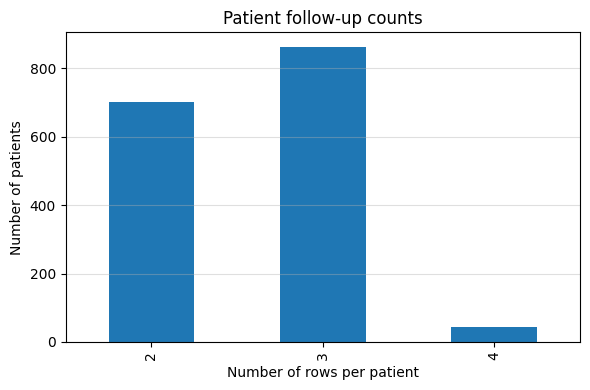


Multi-row dataset: 4,168 rows from 1,608 patients.
Single-row dataset: 0 rows from 0 patients.


In [45]:
# %%
import pandas as pd

ID_COL = "DW_EK_Borger"

# --- group counts ---
patient_counts = df.groupby(ID_COL).size()

n_total = patient_counts.shape[0]
n_single = (patient_counts == 1).sum()
n_multi = (patient_counts >= 2).sum()

print("=== PATIENT GROUP SUMMARY ===")
print(f"Total unique patients: {n_total:,}")
print(f"Patients with only one row: {n_single:,} ({n_single/n_total:.1%})")
print(f"Patients with ≥2 rows: {n_multi:,} ({n_multi/n_total:.1%})")

print("\nDistribution of number of rows per patient:")
print(patient_counts.value_counts().sort_index())

# --- visualize distribution ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
patient_counts.value_counts().sort_index().plot(kind="bar")
plt.xlabel("Number of rows per patient")
plt.ylabel("Number of patients")
plt.title("Patient follow-up counts")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

# --- subset creation ---
df_multi = df[df[ID_COL].isin(patient_counts[patient_counts >= 2].index)].copy()
df_single = df[df[ID_COL].isin(patient_counts[patient_counts == 1].index)].copy()

print(f"\nMulti-row dataset: {df_multi.shape[0]:,} rows from {n_multi:,} patients.")
print(f"Single-row dataset: {df_single.shape[0]:,} rows from {n_single:,} patients.")


In [51]:
import pandas as pd

# --- Inputs ---
ID_COL = "DW_EK_Borger"
WHO_COL = "who_score"

# Load data
df = pd.read_excel(r"C:\Users\kfq6\Documents\Data\Sammedag_master_means.xlsx")


# --- Keep only patients with ≥2 rows (drop single-visit patients) ---
patient_counts = df.groupby(ID_COL).size()

multi_ids = patient_counts[patient_counts >= 2].index

print(f"\nKeeping only patients with ≥2 rows...")
print(f"Patients before filter: {patient_counts.shape[0]:,}")
print(f"Patients with ≥2 rows:  {len(multi_ids):,}")
print(f"Patients dropped (only 1 row): {(patient_counts.shape[0] - len(multi_ids)):,}")

# Overwrite df with multi-row cohort
df = df[df[ID_COL].isin(multi_ids)].copy()

print(f"\nFiltered dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients after filter: {df[ID_COL].nunique():,}")



# 1) Row-level flag: is WHO-5 missing on this row?
df["who_missing_row"] = df[WHO_COL].isna()

# 2) Patient-level: does the patient EVER have a WHO-5?
patient_has_any_who = (
    df.groupby(ID_COL)[WHO_COL]
      .apply(lambda x: x.notna().any())
      .rename("patient_has_any_who")
)

df = df.merge(patient_has_any_who, on=ID_COL)

# 3) Patient-level: is the patient NEVER having WHO-5 on ANY row?
df["patient_never_has_WHO"] = ~df["patient_has_any_who"]

# 4) Rows where WHO-5 is missing BUT patient has WHO-5 elsewhere
df["who_missing_in_partial_patient"] = (
    df["who_missing_row"] & df["patient_has_any_who"]
)



# --- Summaries ---

total_patients = df[ID_COL].nunique()
patients_never_who = (
    df.loc[df["patient_never_has_WHO"], ID_COL]
      .drop_duplicates()
)
patients_partial_who = (
    df.loc[df["who_missing_in_partial_patient"], ID_COL]
      .drop_duplicates()
)

print(f"Total patients: {total_patients}")
print(f"Patients with NO WHO-5 at all: {len(patients_never_who)}")
print(f"Patients with PARTIAL WHO-5 (some rows missing, some present): {len(patients_partial_who)}")

print("\nExample rows with missing WHO-5 in patients who have it elsewhere:")
print(
    df.loc[df["who_missing_in_partial_patient"],
           [ID_COL, "anchor_date", WHO_COL, "who_missing_row", "patient_has_any_who"]]
      .sort_values([ID_COL, "anchor_date"])
      .head(20)
)



Keeping only patients with ≥2 rows...
Patients before filter: 2,037
Patients with ≥2 rows:  1,608
Patients dropped (only 1 row): 429

Filtered dataset shape: 4,168 rows × 36 columns
Unique patients after filter: 1,608
Total patients: 1608
Patients with NO WHO-5 at all: 264
Patients with PARTIAL WHO-5 (some rows missing, some present): 758

Example rows with missing WHO-5 in patients who have it elsewhere:
    DW_EK_Borger anchor_date  who_score  who_missing_row  patient_has_any_who
0           2822  2023-11-13        NaN             True                 True
4           4001  2022-05-12        NaN             True                 True
7           7036  2025-05-21        NaN             True                 True
9           7371  2024-02-13        NaN             True                 True
10          7371  2025-03-05        NaN             True                 True
18         10834  2023-05-24        NaN             True                 True
19         10834  2024-06-05        NaN     

In [52]:
import pandas as pd

# === Inputs ===
LAB_PATH = r"C:\Users\kfq6\Documents\Data\LABKA.xlsx"  # <-- ret til korrekt filnavn
ID_COL = "DW_EK_Borger"

# Tjek at multi_ids findes fra din tidligere celle
try:
    multi_ids
except NameError:
    raise RuntimeError(
        "multi_ids er ikke defineret. Kør cellen med Sammedag_master_means-filtreringen først."
    )

# === 1. Indlæs originalt LAB-datasæt ===
labs = pd.read_excel(LAB_PATH)

# Sikr at dato-kolonnen er i datetime-format
labs["Dato_Proevetagningstid"] = pd.to_datetime(
    labs["Dato_Proevetagningstid"], errors="coerce"
)

# Smid rækker uden gyldig prøvedato
labs = labs[~labs["Dato_Proevetagningstid"].isna()].copy()

# Tilføj år
labs["year"] = labs["Dato_Proevetagningstid"].dt.year

# Begræns til 2022 og frem
labs = labs[labs["year"] >= 2022].copy()

# === 2. Begræns til inkluderede patienter (kun dem med ≥2 sammedagsscreeninger) ===
labs = labs[labs[ID_COL].isin(multi_ids)].copy()

print(f"Antal inkluderede patienter i LAB-datasættet: {labs[ID_COL].nunique()}")
print(f"Antal LAB-rækker (tests) fra 2022+: {len(labs):,}")

# === 3. Beregn antal prøver per patient per år ===
per_patient_year = (
    labs
    .groupby([ID_COL, "year"])
    .agg(
        n_tests_total=("Analysenavn", "size"),              # alle rækker = alle prøvesvar
        n_unique_analyses=("Analysenavn", "nunique"),       # forskellige analysetyper
        n_unique_test_dates=("Dato_Proevetagningstid", "nunique")  # hvor mange datoer
    )
    .reset_index()
)

print("\nEksempel på patient-år niveau (top 10 rækker):")
print(per_patient_year.head(10))

# === 4. Årsoversigt for hele kohorten ===
year_summary = (
    per_patient_year
    .groupby("year")
    .agg(
        n_patients=("DW_EK_Borger", "nunique"),
        mean_tests_per_patient=("n_tests_total", "mean"),
        median_tests_per_patient=("n_tests_total", "median"),
        mean_unique_analyses=("n_unique_analyses", "mean"),
        median_unique_analyses=("n_unique_analyses", "median"),
    )
    .reset_index()
)

print("\nÅrsoversigt for inkluderede patienter (2022+):")
print(year_summary.to_string(index=False))


c:\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Antal inkluderede patienter i LAB-datasættet: 1608
Antal LAB-rækker (tests) fra 2022+: 197,857

Eksempel på patient-år niveau (top 10 rækker):
   DW_EK_Borger  year  n_tests_total  n_unique_analyses  n_unique_test_dates
0          2822  2022              1                  1                    1
1          2822  2023             25                 13                    3
2          2822  2025             12                 12                    1
3          2897  2022             65                 15                    7
4          2897  2023             22                  9                    3
5          2897  2024             49                 15                    5
6          2897  2025             43                 15                    3
7          4001  2022             41                 13                    5
8          4001  2023             62                 15                    9
9          4001  2024            401                 15                   56

Årsoversi